## GRAD CAM

This code is an implementation of GRAD CAM the aim of the code is to provide visual explanation maps to a batch of test images. 

In [1]:
## Import necessary Libraries

import tensorflow.compat.v1 as tf
import numpy as np
import keras
from keras import backend as K
from skimage import io
from skimage.transform import resize
from scipy.misc import imread, imresize
from keras.layers.core import Lambda
from keras.models import Sequential
from keras.models import Model
from matplotlib import pyplot as plt
import os
tf.compat.v1.disable_eager_execution()
import cv2

2021-12-07 02:09:34.094437: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noetic/lib:/opt/ros/noetic/lib/x86_64-linux-gnu:/usr/local/lib
2021-12-07 02:09:34.094459: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
## Uncomment the model that you prefer to use

# InputModel = tf.keras.applications.VGG16(
#     include_top=True,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=None,
#     pooling=None,
#     classes=1000,
#     classifier_activation="softmax",
# )

InputModel = tf.keras.applications.EfficientNetB0(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
#     **kwargs
)


# InputModel = tf.keras.applications.ResNet50(
#     include_top=True,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=None,
#     pooling=None,
#     classes=1000,
#    # **kwargs
# )


# InputModel = tf.keras.applications.ResNet101(
#     include_top=True,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=None,
#     pooling=None,
#     classes=1000,
#    # **kwargs
# )

Instructions for updating:
Colocations handled automatically by placer.


2021-12-07 02:09:35.694129: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sudarshan/Documents/Mobile Robotics/SMAI_project/SMAI/lib/python3.8/site-packages/cv2/../../lib64:/opt/ros/noetic/lib:/opt/ros/noetic/lib/x86_64-linux-gnu:/usr/local/lib
2021-12-07 02:09:35.694150: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-07 02:09:35.694165: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sudarshan): /proc/driver/nvidia/version does not exist
2021-12-07 02:09:39.136464: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable t

In [3]:
## Display the various layers in the input model note down the name of the final convolutional layer 

InputModel.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0

In [4]:
##  construct a loss function that returns the value at the output layer responsible for the given prediction  

def target_category_loss(x, category_index, nb_classes):
    return tf.multiply(x, K.one_hot([category_index], nb_classes))

In [5]:
def target_category_loss_output_shape(input_shape):
    return input_shape

In [6]:
def normalize(x):
    # Return L2 norm of the Input Tensor 
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

In [7]:
def GRAD_CAM( x , layer_name  , Img   ):
    
    sess = tf.Session()
    prob = InputModel.predict(x)
    input_img =  x
    
    k = 5
    top_k = tf.keras.applications.imagenet_utils.decode_predictions(prob, k)
    
    predicted_class = np.argmax(prob)
    layer_name = layer_name  
    NumClasses = np.shape(prob)[1]
    print(predicted_class)
    
#     print( InputModel.layers[-2].output)
    
    data = Img + " " + str(prob[0][predicted_class]) + " " + str(predicted_class) + "\n"
    
    file1.write( data )
    
    target_layer = lambda x: target_category_loss(x, predicted_class, NumClasses)
    x = Lambda(target_layer, output_shape = target_category_loss_output_shape)(InputModel.output)
    model = Model(inputs=InputModel.input, outputs=x)
    
    loss = K.sum(model.output)
    
    for l in model.layers:
        
        if( l.name == layer_name ):
            conv_output = l.output
    
    grads = normalize(K.gradients(loss, conv_output)[0])
    gradient_function = K.function([model.layers[0].input], [conv_output, grads])
    
    output, grads_val = gradient_function([input_img])
    output = output[ 0 , :]
    grads_val = grads_val[0 , :]
    
    weights_k_c = np.mean( grads_val , axis=(0 , 1 ) )
    dim = np.shape(output)[0]
    localization_result = np.ones( (dim, dim) , dtype =np.float32 )
    
    for i in range( len(weights_k_c)):
        localization_result += weights_k_c[i]*output[: , : , i]

    
    localization_result = np.maximum (localization_result , 0 )
    localization_result = localization_result / np.max(localization_result)
    localization_result = resize(localization_result, (224,224))
    cam3 = np.expand_dims(localization_result, axis=2)
    cam3 = np.tile(cam3,[1,1,3])
    
    img_eval_average_drop = img.astype(float)

    img_eval_average_drop /= img_eval_average_drop.max()
    img_eval_average_drop = img_eval_average_drop*cam3
    img_eval_average_drop /= img_eval_average_drop.max()
    
    print(" Localization Map")
    io.imshow(cam3)
    plt.show()
    
#     GetSegmentation( cam3 , img  , Img )
    
    print( "Overlaying on actual Image ")
    
    io.imshow(img_eval_average_drop)
    plt.show()
    
    name = Img + ".png"
    path = "Results/GRAD_CAM/"
    path = os.path.join( path, name)   
    cv2.imwrite(path , 255*img_eval_average_drop   )
    
    print("----------------------")
    

In [8]:
def GetSegmentation( cam3 , img , Img ):
    
    dim = np.shape(cam3)
    img2 = img
    alpha = 0.4
    pixel_counter = 0 
    
    save_dir = '/home/sudarshan/Documents/Mobile Robotics/SMAI_project/SAS/Results/GRAD_CAM_res2'
    save_dir = os.path.join(save_dir , Img  )
    
    for i in range( dim[0]):
        for j in range( dim[1]):
            if(  255*cam3[i][j][0] > 20 ):
                img2[i][j] =  np.clip(alpha*img[i][j][0]  + (1- alpha) , 0, 255)  #img[i][j] +  [ 50, 0  , 0 ]
                pixel_counter += 1 
    
    
    print( pixel_counter )
    img2 = cv2.cvtColor(img2 , cv2.COLOR_BGR2RGB ) 
    cv2.imwrite( save_dir , img2 )
    plt.imshow( img2 )
    plt.show()
    

/tmp/ipykernel_53920/3949155034.py:19: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  img = imread(Img_path, mode='RGB')
/tmp/ipykernel_53920/3949155034.py:20: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  img = imresize(img, (224, 224))
/home/sudarshan/Documents/Mobile Robotics/SMAI_project/SMAI/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


285
 Localization Map


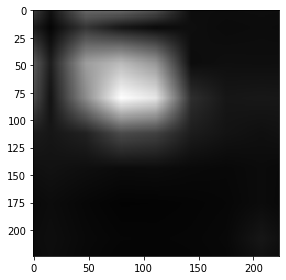

Overlaying on actual Image 


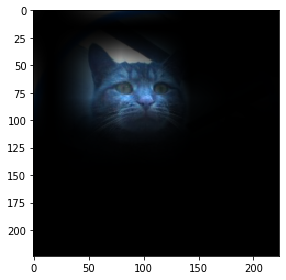

----------------------
1
 Localization Map


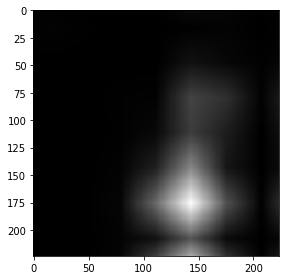

Overlaying on actual Image 


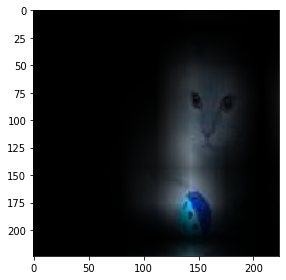

----------------------
283
 Localization Map


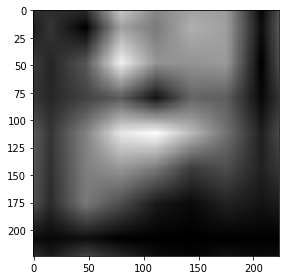

Overlaying on actual Image 


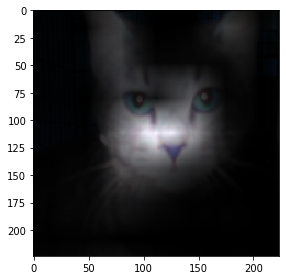

----------------------
211
 Localization Map


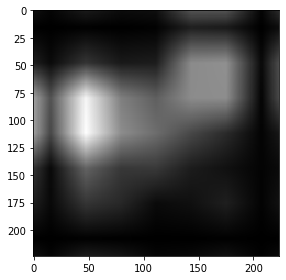

Overlaying on actual Image 


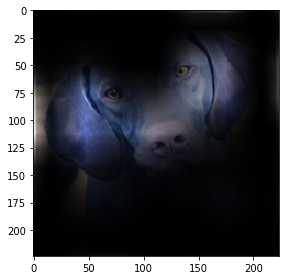

----------------------
285
 Localization Map


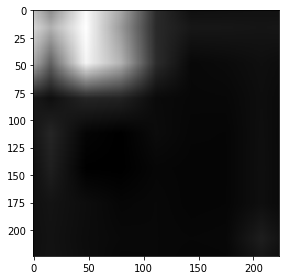

Overlaying on actual Image 


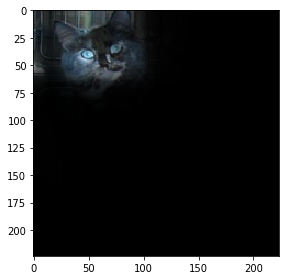

----------------------
151
 Localization Map


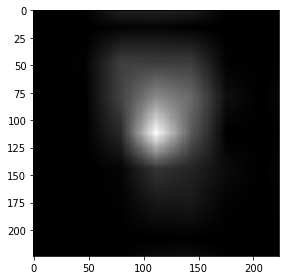

Overlaying on actual Image 


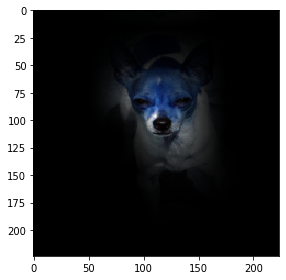

----------------------
497
 Localization Map


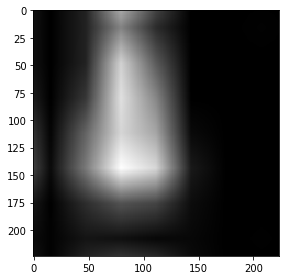

Overlaying on actual Image 


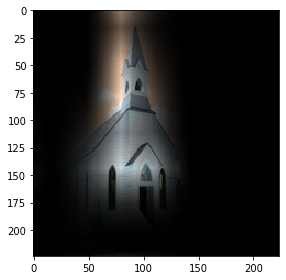

----------------------
332
 Localization Map


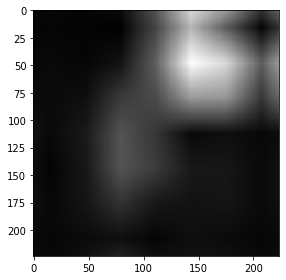

Overlaying on actual Image 


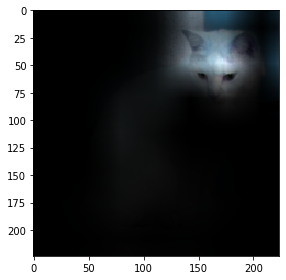

----------------------
333
 Localization Map


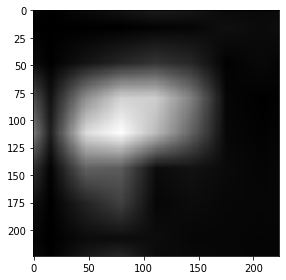

Overlaying on actual Image 


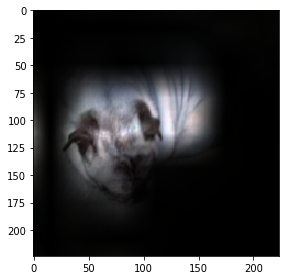

----------------------
211
 Localization Map


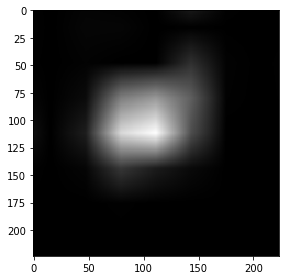

Overlaying on actual Image 


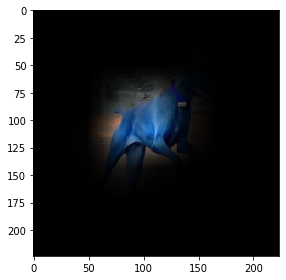

----------------------
644
 Localization Map


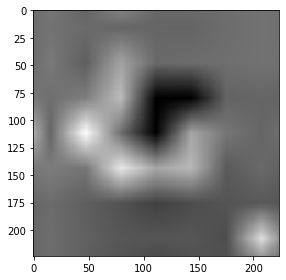

Overlaying on actual Image 


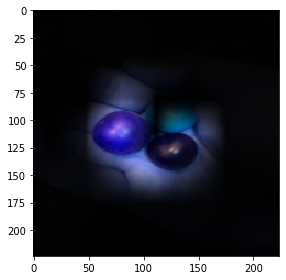

----------------------
262
 Localization Map


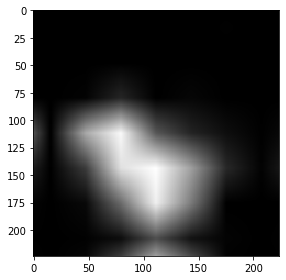

Overlaying on actual Image 


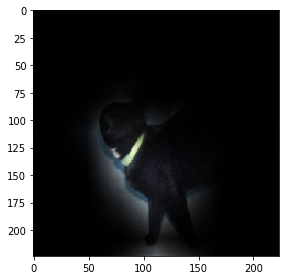

----------------------
285
 Localization Map


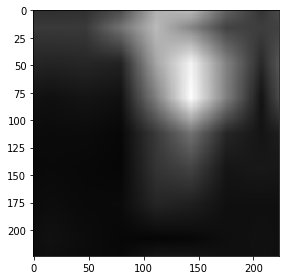

Overlaying on actual Image 


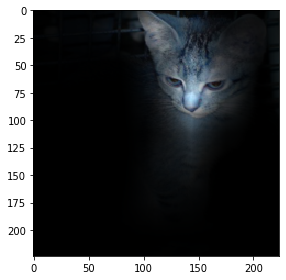

----------------------
29
 Localization Map


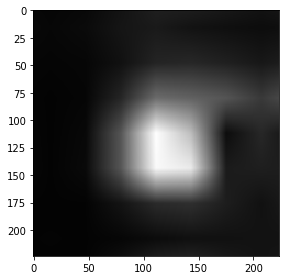

Overlaying on actual Image 


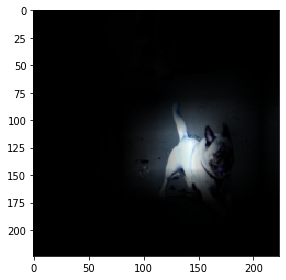

----------------------
332
 Localization Map


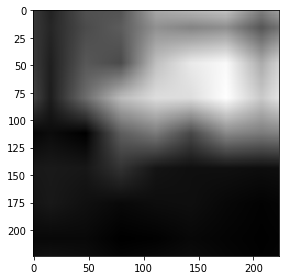

Overlaying on actual Image 


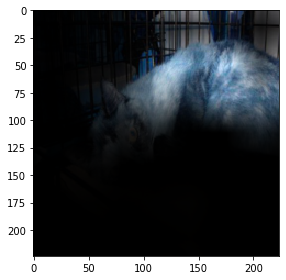

----------------------
285
 Localization Map


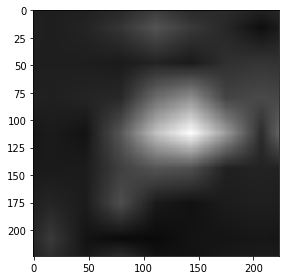

Overlaying on actual Image 


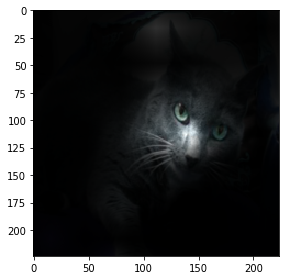

----------------------
245
 Localization Map


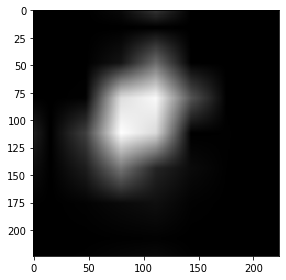

Overlaying on actual Image 


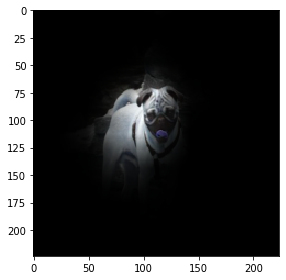

----------------------
31
 Localization Map


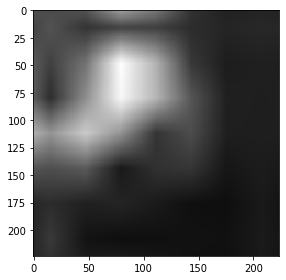

Overlaying on actual Image 


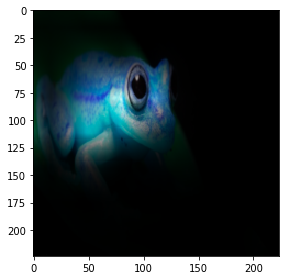

----------------------
283
 Localization Map


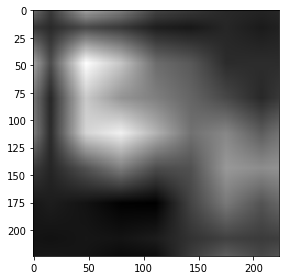

Overlaying on actual Image 


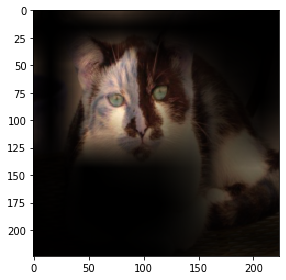

----------------------
151
 Localization Map


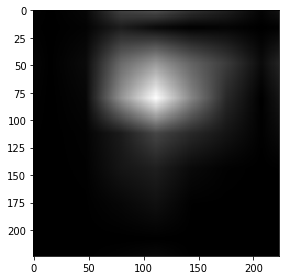

Overlaying on actual Image 


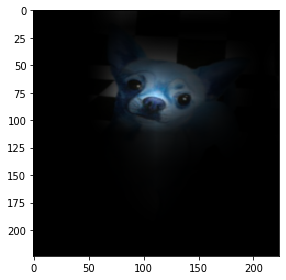

----------------------
989
 Localization Map


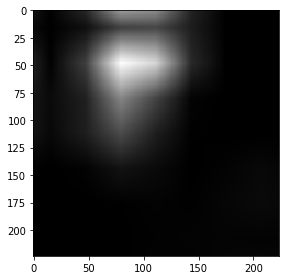

Overlaying on actual Image 


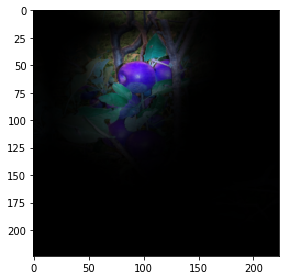

----------------------
332
 Localization Map


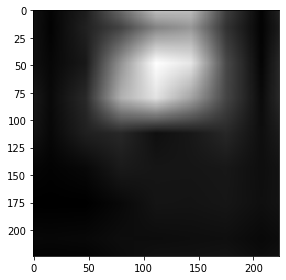

Overlaying on actual Image 


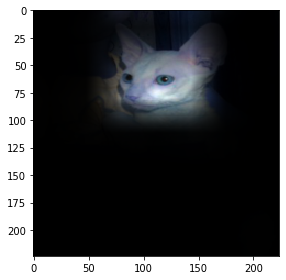

----------------------
162
 Localization Map


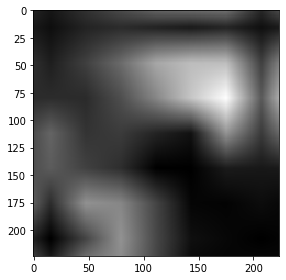

Overlaying on actual Image 


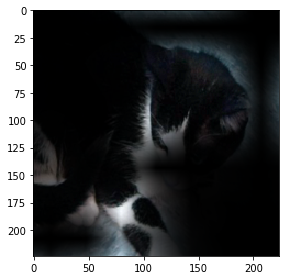

----------------------
456
 Localization Map


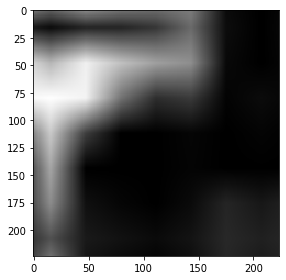

Overlaying on actual Image 


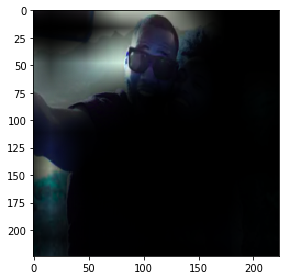

----------------------
285
 Localization Map


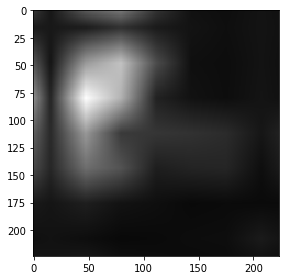

Overlaying on actual Image 


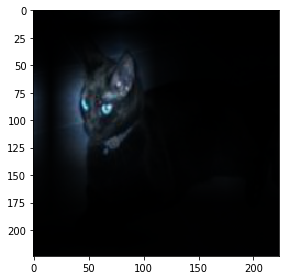

----------------------
259
 Localization Map


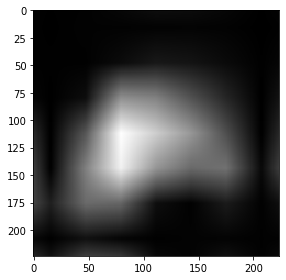

Overlaying on actual Image 


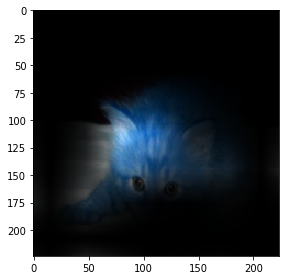

----------------------
283
 Localization Map


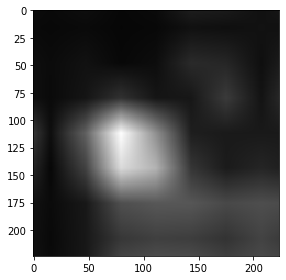

Overlaying on actual Image 


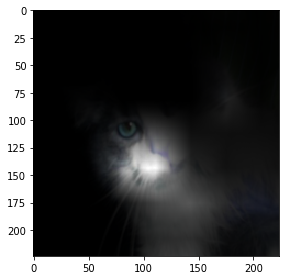

----------------------
954
 Localization Map


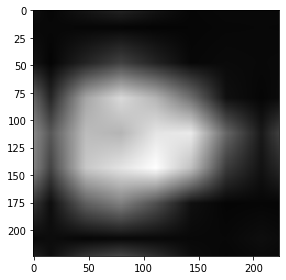

Overlaying on actual Image 


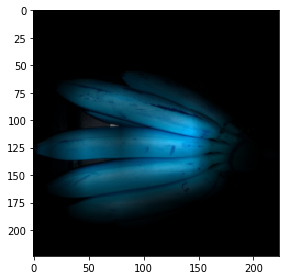

----------------------
283
 Localization Map


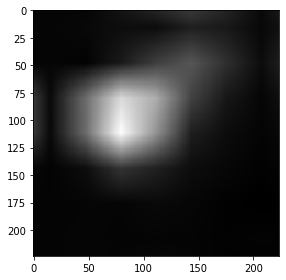

Overlaying on actual Image 


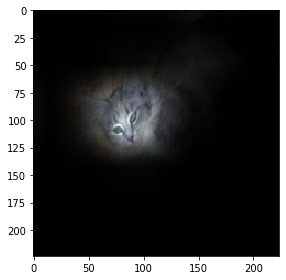

----------------------
285
 Localization Map


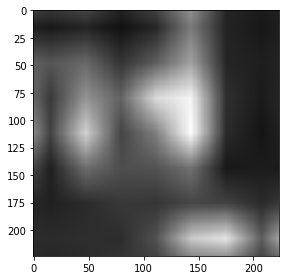

Overlaying on actual Image 


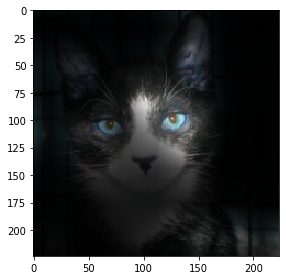

----------------------
101
 Localization Map


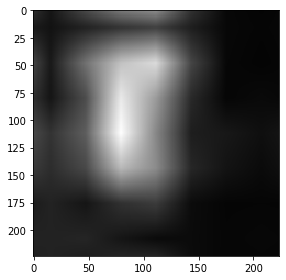

Overlaying on actual Image 


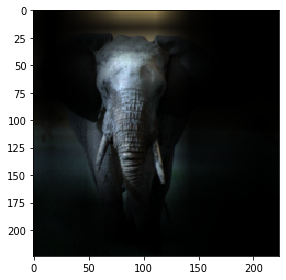

----------------------
285
 Localization Map


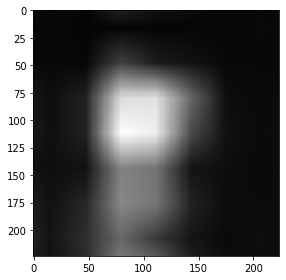

Overlaying on actual Image 


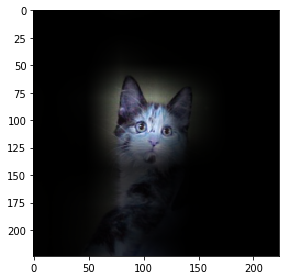

----------------------
211
 Localization Map


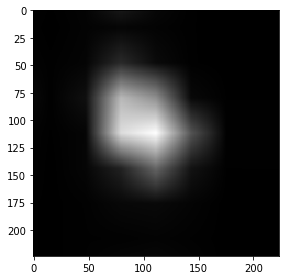

Overlaying on actual Image 


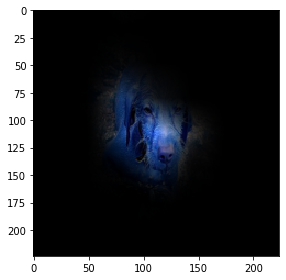

----------------------
151
 Localization Map


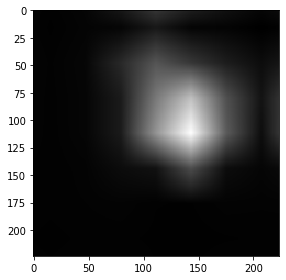

Overlaying on actual Image 


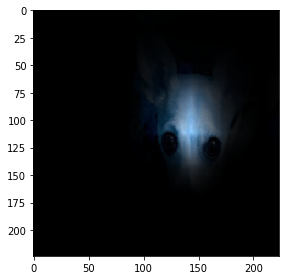

----------------------
285
 Localization Map


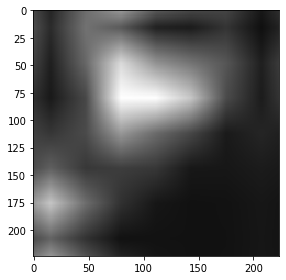

Overlaying on actual Image 


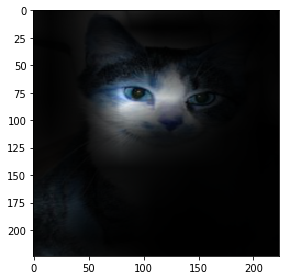

----------------------
957
 Localization Map


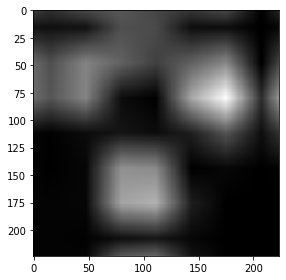

Overlaying on actual Image 


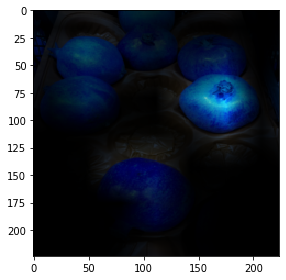

----------------------
211
 Localization Map


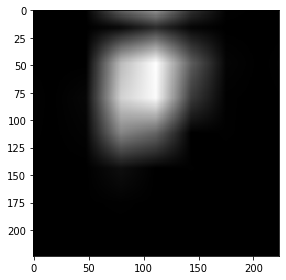

Overlaying on actual Image 


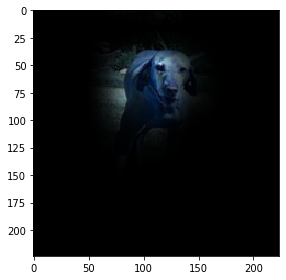

----------------------
211
 Localization Map


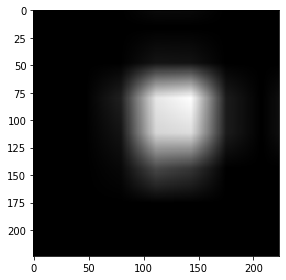

Overlaying on actual Image 


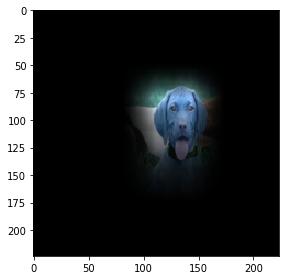

----------------------
356
 Localization Map


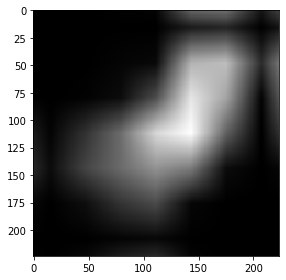

Overlaying on actual Image 


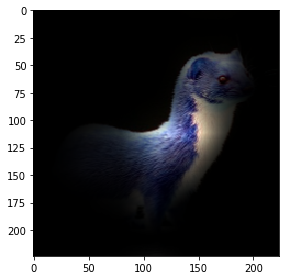

----------------------
333
 Localization Map


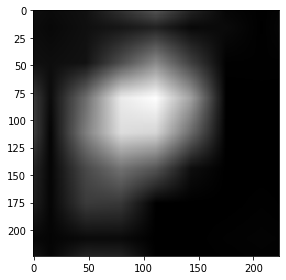

Overlaying on actual Image 


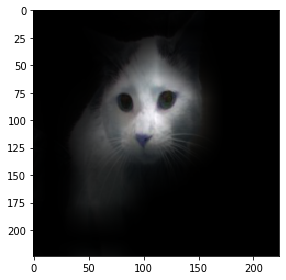

----------------------
285
 Localization Map


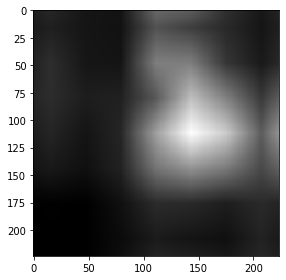

Overlaying on actual Image 


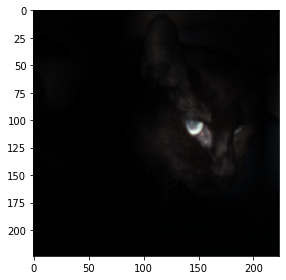

----------------------
281
 Localization Map


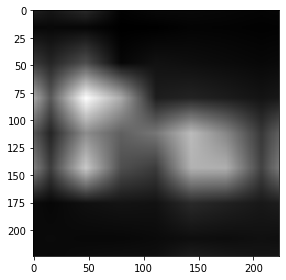

Overlaying on actual Image 


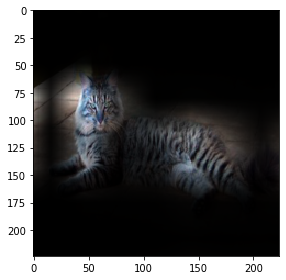

----------------------
285
 Localization Map


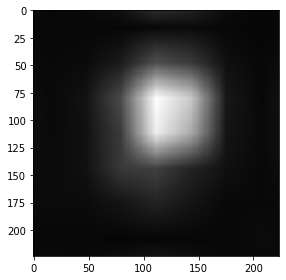

Overlaying on actual Image 


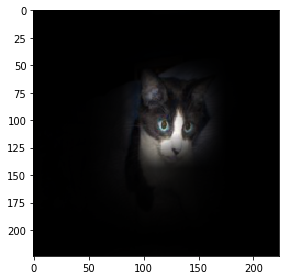

----------------------
254
 Localization Map


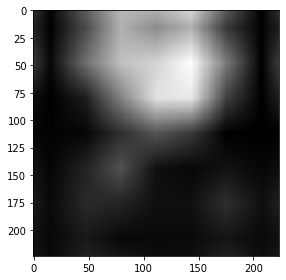

Overlaying on actual Image 


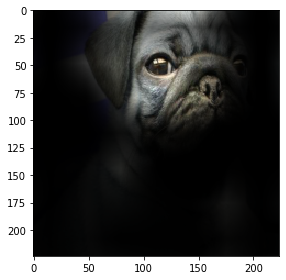

----------------------
332
 Localization Map


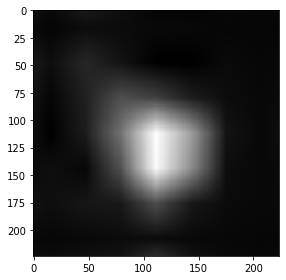

Overlaying on actual Image 


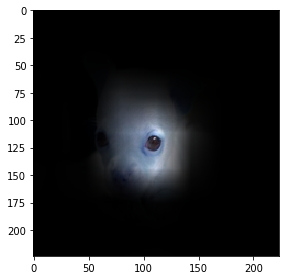

----------------------
283
 Localization Map


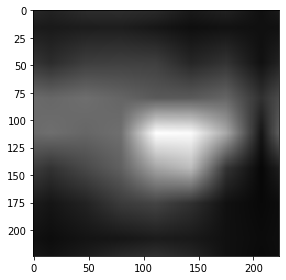

Overlaying on actual Image 


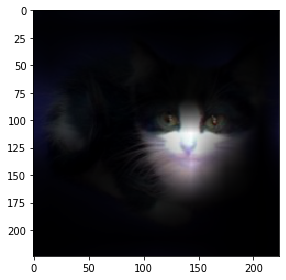

----------------------
954
 Localization Map


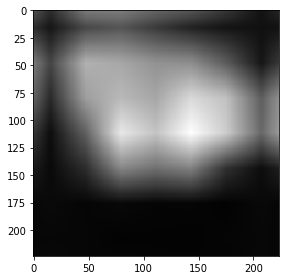

Overlaying on actual Image 


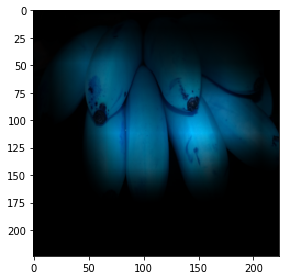

----------------------
285
 Localization Map


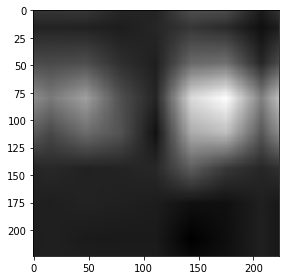

Overlaying on actual Image 


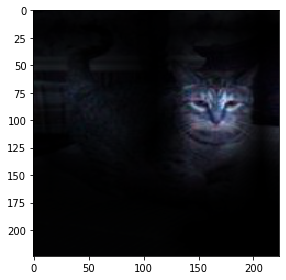

----------------------
283
 Localization Map


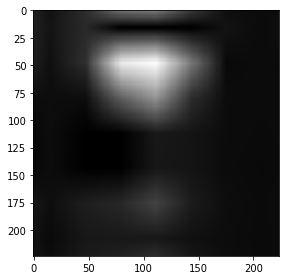

Overlaying on actual Image 


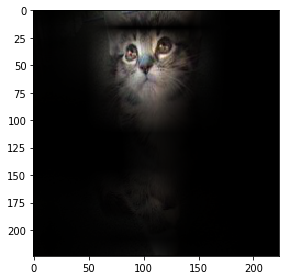

----------------------
285
 Localization Map


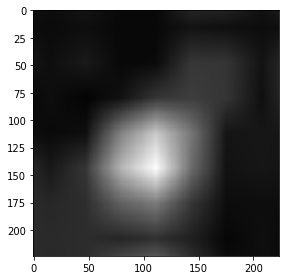

Overlaying on actual Image 


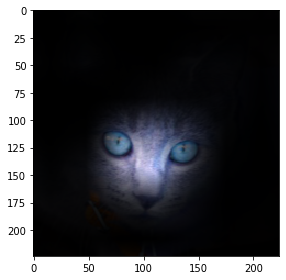

----------------------
374
 Localization Map


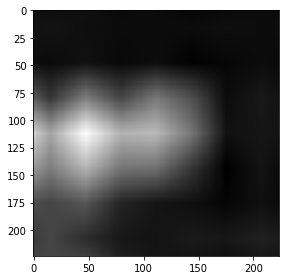

Overlaying on actual Image 


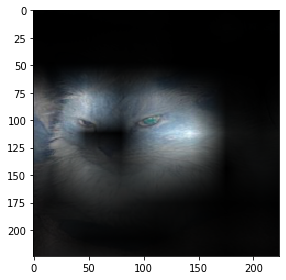

----------------------
151
 Localization Map


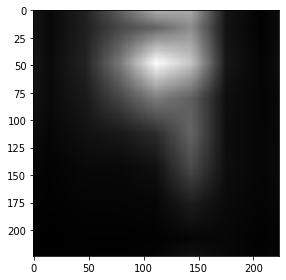

Overlaying on actual Image 


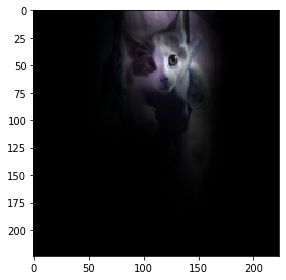

----------------------
151
 Localization Map


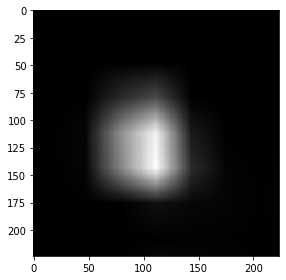

Overlaying on actual Image 


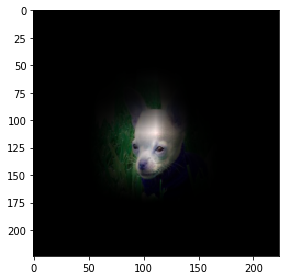

----------------------
373
 Localization Map


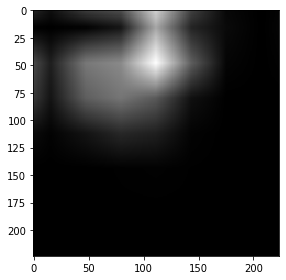

Overlaying on actual Image 


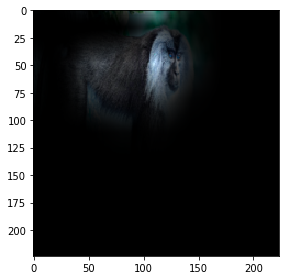

----------------------
283
 Localization Map


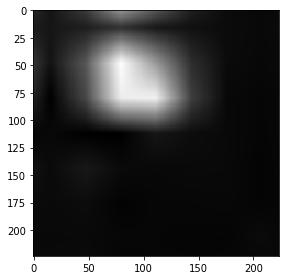

Overlaying on actual Image 


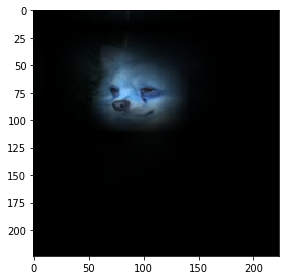

----------------------
285
 Localization Map


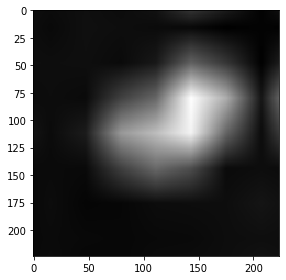

Overlaying on actual Image 


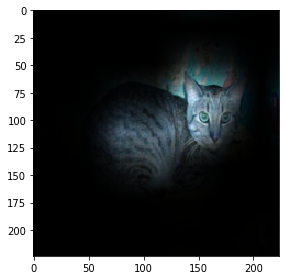

----------------------
283
 Localization Map


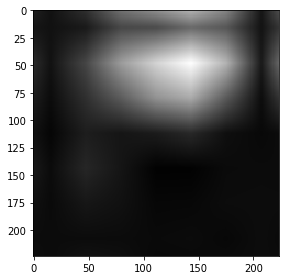

Overlaying on actual Image 


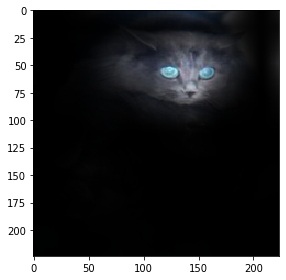

----------------------
281
 Localization Map


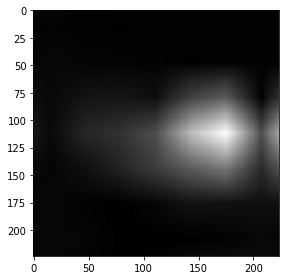

Overlaying on actual Image 


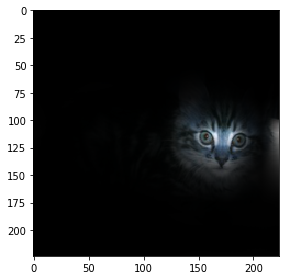

----------------------
254
 Localization Map


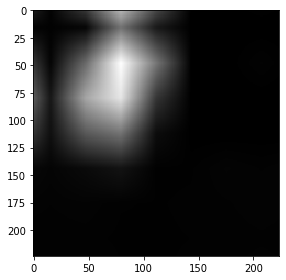

Overlaying on actual Image 


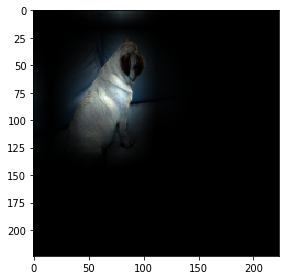

----------------------
285
 Localization Map


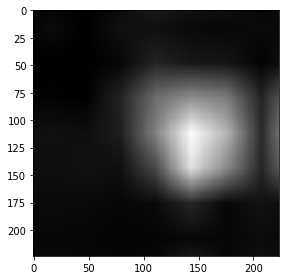

Overlaying on actual Image 


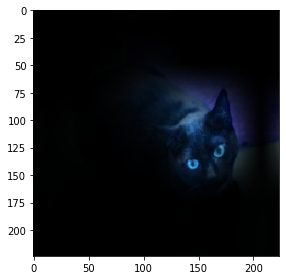

----------------------
285
 Localization Map


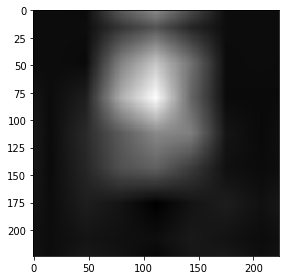

Overlaying on actual Image 


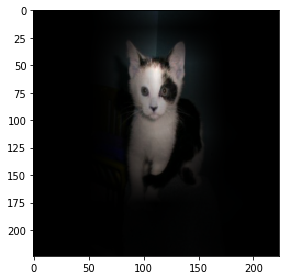

----------------------
283
 Localization Map


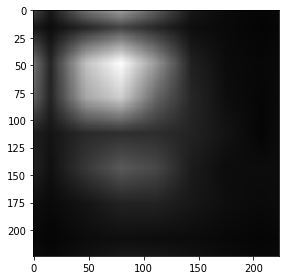

Overlaying on actual Image 


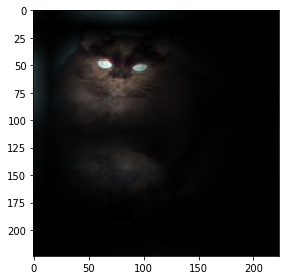

----------------------


In [9]:
test_data_dir = 'Results/GRAD_CAM'
Imgs_names = os.listdir(test_data_dir)

## According to the choosen model set appropriate name for the layer 
## EfficientNet = 'top_activation'
## VGG = 'block5_pool'
## Resnet50/101 = 'conv5_block3_out'


layer_name = 'top_activation'



file1 = open("grad_cam_explanation.txt","a")

for Img in Imgs_names:
    
    Img_path = os.path.join(test_data_dir , Img )
    img = imread(Img_path, mode='RGB')
    img = imresize(img, (224, 224))
    x = np.expand_dims(img, axis=0) # [224,224 , 3 ] -> [1 , 224,224 , 3 ]
    x = x[:,:,:,::-1]
    GRAD_CAM( x , layer_name  , Img   )
    
file1.close()